In [1]:
!pip install scikit-learn numpy scipy nltk pandas transformers

'''
Ensure the fnc-1 dataset is located in the same directory as this notebook, in a folder called 'fnc-1', as follows:
    - fnc-1
        - ______.csv
    - nlp_fnc-1_vmrj42.ipynb
'''

In [1]:
from __future__ import division
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, classification_report
from nltk.corpus import stopwords
from scipy import sparse
from scipy.sparse import hstack
import nltk
import pandas as pd
import csv
import sys, os
import pickle
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers

import time
import random
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

try:
    stopwords.words('english')
except:
    nltk.download('stopwords')

PUNCTUATION = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# Retrieving the dataset
class Dataset():
    def __init__(self, name='train', path='fnc-1', size=1, clean=True, balance=False, validation=False, related_only=False):
        self.path = path

        if not os.path.isfile('%s/%s_all_%s_%s.csv' % (path, name, 'processed' if clean else 'unprocessed', 'balanced' if balance else 'unbalanced')):
            print('Generating')
            bodies = name + '_bodies.csv'
            stances = name + '_stances.csv'
            self.articles = self.read(bodies)
            self.stances = self.read(stances)

            self.articles = pd.read_csv('%s/%s' % (path, bodies))
            self.stances = pd.read_csv('%s/%s' % (path, stances))

            pd.options.display.max_columns = None
            self.data = pd.merge(self.articles, self.stances, how='right', on='Body ID')
            for index, d in self.data.iterrows():
                self.data.at[index, 'Body ID'] = int(d['Body ID'])
                if clean:
                    self.data.at[index, 'Headline'] = preprocess(d['Headline'])
                    self.data.at[index, 'articleBody'] = preprocess(d['articleBody'])
                    
            self.data.to_csv('%s/%s_all_%s_%s.csv' % (path, name, 'processed' if clean else 'unprocessed', 'balanced' if balance else 'unbalanced'), index = False)
            
            if balance:
                data = self.read('%s_all_%s_%s.csv' % (name, 'processed' if clean else 'unprocessed', 'balanced' if balance else 'unbalanced'))
                n_related = sum([0 if d['Stance'] == 'unrelated' else 1 for d in data])
                print(n_related)
                dataset_size = len(data)
                for _ in range(dataset_size - (2 * n_related)):
                    n = len(data) - 1
                    while True:
                        if data[n]['Stance'] == 'unrelated':
                            del data[n]
                            break
                        n -= 1
                random.shuffle(data)
                self.write('%s_all_%s_%s.csv' % (name, 'processed' if clean else 'unprocessed', 'balanced' if balance else 'unbalanced'), data)    
            
        self.data = self.read('%s_all_%s_%s.csv' % (name, 'processed' if clean else 'unprocessed', 'balanced' if balance else 'unbalanced'))
        if related_only:
            self.data = [d for d in self.data if d['Stance'] != 'unrelated']
        self.data = self.data[:int(len(self.data) * size)]
        all_headlines = [d['Headline'] for d in self.data]
        all_bodies = [d['articleBody'] for d in self.data]
        self.all_text = [' '.join([a,b]) for a,b in zip(all_headlines, all_bodies)]
        
        if validation:
            self.validation = self.data[-3000:]
            self.data = self.data[:-3000]
        

    def read(self, filename):
        rows = []
        with open(self.path + '/' + filename, 'r', encoding='utf-8') as table:
            r = csv.DictReader(table)
            for line in r:
                rows.append(line)
        return rows
    
    def write(self, filename, data):
        print(list(data[0].keys()))
        with open(self.path + '/' + filename, 'w', encoding='utf-8') as table:
            w = csv.DictWriter(table, fieldnames = list(data[0].keys()))
            w.writeheader()
            for row in data:
                w.writerow(row)
    
# Function to pre-process the sentences before Tf-idf vectorization
def preprocess(data):
    from nltk.tokenize import word_tokenize
    from nltk.stem.porter import PorterStemmer
    import string
    tokens = word_tokenize(data)
    tokens = [token.lower() for token in tokens]
    table = str.maketrans('', '', PUNCTUATION)
    tokens = [token.translate(table) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]
    porter = PorterStemmer()
    tokens = [porter.stem(token) for token in tokens]
    return ' '.join(tokens)

In [3]:
def cosine_sim(x,y):
    try:
        if type(x) is np.ndarray: x = x.reshape(1, -1) # get rid of the warning
        if type(y) is np.ndarray: y = y.reshape(1, -1)
        d = cosine_similarity(x, y)
        d = d[0][0]
    except:
        print(x)
        print(y)
        d = 0.
    return d

def euclidean_dist(x,y):
    try:
        if type(x) is np.ndarray: x = x.reshape(1, -1) # get rid of the warning
        if type(y) is np.ndarray: y = y.reshape(1, -1)
        d = euclidean_distances(x, y)
        d = d[0][0]
    except:
        print(x)
        print(y)
        d = 0.
    return d

In [4]:
def classify_tfidf(mode, classifier = 'svm'):
    print('Configuration: %s, %s' % (mode, classifier))

    # Load the pre-processed datasets
    train_dataset = Dataset()
    test_dataset = Dataset(name='competition_test')
    print('Datasets loaded')
    # Instantiate the vocabulary
    vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2)
    vec.fit(train_dataset.all_text + test_dataset.all_text)
    vocab = vec.vocabulary_
    print('Vocabulary initialized')

    # Select the classifier model
    if classifier == 'randforest':
        model = RandomForestClassifier(n_estimators=1000, random_state=0)
    elif classifier == 'svm':
        model = SVC()
    elif classifier == 'lr':
        model = LogisticRegression(C=2, class_weight = 'balanced')

    # Select the load/save functions, depending on the type of feature generated
    if mode == 'sim':
        ext = 'npy'
        load = np.load
        save = np.save
    else:
        ext = 'npz'
        load = sparse.load_npz
        save = sparse.save_npz

    if os.path.isfile('features/tfidf_train_%s.%s' % (mode, ext)):
        X_train = load('features/tfidf_train_%s.%s' % (mode, ext))
        X_test = load('features/tfidf_test_%s.%s' % (mode, ext))
    else:
        # Combine the headline and body into a single sentence, and use that as the input
        if mode == 'combine':
            # Generate the Tf-idf features for both datasets
            vecHB = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2, vocabulary=vocab)
            tfidfHB = vecHB.fit_transform([' '.join([d['Headline'], d['articleBody']]) for d in train_dataset.data])
            print('tfidfs for headlines + bodies generated ', tfidfHB.shape)
            test_vecHB = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2, vocabulary=vocab)
            test_tfidfHB = test_vecHB.fit_transform([' '.join([d['Headline'], d['articleBody']]) for d in test_dataset.data])
            print('tfidfs for test headlines + bodies generated ', test_tfidfHB.shape)

            X_train = tfidfHB
            X_test = test_tfidfHB
        else:
            # Generate the Tf-idf features for both datasets, headlines and bodies separately
            vecH = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2, vocabulary=vocab)
            tfidfH = vecH.fit_transform([d['Headline'] for d in train_dataset.data])
            print('tfidfs for headlines generated ', tfidfH.shape)
            test_vecH = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2, vocabulary=vocab)
            test_tfidfH = test_vecH.fit_transform([d['Headline'] for d in test_dataset.data])
            print('tfidfs for test headlines generated ', test_tfidfH.shape)

            vecB = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2, vocabulary=vocab)
            tfidfB = vecB.fit_transform([d['articleBody'] for d in train_dataset.data])
            print('tfidfs for bodies generated ', tfidfB.shape)
            test_vecB = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=2, vocabulary=vocab)
            test_tfidfB = test_vecB.fit_transform([d['articleBody'] for d in test_dataset.data])
            print('tfidfs for test bodies generated ', test_tfidfB.shape)

            # Handle different feature modes separately
            if mode == 'sim':
                # Find some similarity metrics. In this case, we use cosine similarity and euclidean distance
                cos_sim = np.asarray(list(map(cosine_sim, tfidfH, tfidfB)))[:, np.newaxis]
                print('cos similarity between header and body tfidfs generated ', cos_sim.shape)
                euclid_dist = np.asarray(list(map(euclidean_dist, tfidfH, tfidfB)))[:, np.newaxis]
                print('euclidean distances between header and body tfidfs generated ', euclid_dist.shape)


                test_cos_sim = np.asarray(list(map(cosine_sim, test_tfidfH, test_tfidfB)))[:, np.newaxis]
                print('cos similarity between test header and body tfidfs generated ', test_cos_sim.shape)
                test_euclid_dist = np.asarray(list(map(euclidean_dist, test_tfidfH, test_tfidfB)))[:, np.newaxis]
                print('euclidean distances between test header and body tfidfs generated ', test_euclid_dist.shape)

                X_train = np.concatenate((cos_sim, euclid_dist), axis = 1)
                X_test = np.concatenate((test_cos_sim, test_euclid_dist), axis = 1)
            elif mode == 'cat':
                # Concatenate the two Tf-idf features
                X_train = sparse.hstack([tfidfH, tfidfB])
                X_test = sparse.hstack([test_tfidfH, test_tfidfB])

        save('features/tfidf_train_%s.%s' % (mode, ext), X_train)
        save('features/tfidf_test_%s.%s' % (mode, ext), X_test)


    y_train = [0 if d['Stance'] == 'unrelated' else 1 for d in train_dataset.data]
    y_test = [0 if d['Stance'] == 'unrelated' else 1 for d in test_dataset.data]

    # Fit the model
    if os.path.isfile('models/tfidf_%s_%s.pkl' % (classifier, mode)):
        with open('models/tfidf_%s_%s.pkl' % (classifier, mode), 'rb') as file:
            model = pickle.load(file)
        print('Classifier loaded')
    else:
        model.fit(X_train, y_train)
        print('Classifier trained')
        with open('models/tfidf_%s_%s.pkl' % (classifier, mode), 'wb') as file:
            pickle.dump(model, file)

    # Make some predictions
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred)
    print(report)

In [5]:
# Function to generate BERT features one by one - the dataset is too large to generate features for all documents in one pass
def generate_bert_features(dataset, tokenizer, model, device, split=False, mode='cls', dtype='train', sim=False):
    headlines = [d['Headline'] for d in dataset]
    bodies = [d['articleBody'] for d in dataset]
    feats = []

    # Tokenize the inputs separately if split = True, otherwise tokenize them together
    if split:
        h_encoding = tokenizer(headlines, return_tensors='pt', padding=True, truncation=True)
        b_encoding = tokenizer(bodies, return_tensors='pt', padding=True, truncation=True)
        print('Dataset encoded')
        
        # For every (headline,body) token sequence pair, generate the features
        for h_inp, h_type, h_att, b_inp, b_type, b_att in zip(
            h_encoding['input_ids'], h_encoding['token_type_ids'], h_encoding['attention_mask'], b_encoding['input_ids'], b_encoding['token_type_ids'], b_encoding['attention_mask']
            ):
            h_output = model(h_inp.to(device).unsqueeze(0), token_type_ids = h_type.to(device).unsqueeze(0), attention_mask = h_att.to(device).unsqueeze(0), output_hidden_states=True)
            b_output = model(b_inp.to(device).unsqueeze(0), token_type_ids = b_type.to(device).unsqueeze(0), attention_mask = b_att.to(device).unsqueeze(0), output_hidden_states=True)

            # Use the vector associated with the '[CLS]' tag
            if mode == 'cls':
                h_svec = h_output[0][0][0].squeeze().cpu().detach().numpy()
                b_svec = b_output[0][0][0].squeeze().cpu().detach().numpy()
            # Use the pooled output
            elif mode == 'pooled':
                h_svec = h_output[1][0].squeeze().cpu().detach().numpy()
                b_svec = b_output[1][0].squeeze().cpu().detach().numpy()
            # Concatenate the last 4 hidden layers, and find the mean to get a sentence vector
            elif mode == 'cat':
                h_cat = torch.cat([h_output[2][i] for i in [-1,-2,-3,-4]], dim=-1).squeeze()
                b_cat = torch.cat([b_output[2][i] for i in [-1,-2,-3,-4]], dim=-1).squeeze()
                h_svec = h_cat[0].cpu().detach().numpy()
                b_svec = b_cat[0].cpu().detach().numpy()
            # Either use cosine similarity as a feature, or join the two vectors into one feature
            if sim:
                feats += [[cosine_sim(h_svec, b_svec)]]
            else:
                feats += [np.append(h_svec, b_svec)]

    else:
        encoding = tokenizer(headlines, bodies, return_tensors='pt', padding=True, truncation=True)
        input_ids, token_type_ids, attention_masks = encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']

        for input_id, token_type_id, attention_mask in zip(input_ids, token_type_ids, attention_masks):
            output = model(input_id.to(device).unsqueeze(0), token_type_ids = token_type_id.to(device).unsqueeze(0), attention_mask = attention_mask.to(device).unsqueeze(0), output_hidden_states=True)

            cls_feat = output[0].squeeze()[0]
            pooled_output = output[1].squeeze()

            hidden_states = output[2]
            cat = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1).squeeze()
            
            # Use the '[CLS]' token representing the pair as a feature
            if mode == 'cls':
                feats += [cls_feat.cpu().detach().numpy()]
            # Use the pooled output as a feature
            elif mode == 'pooled':
                feats += [pooled_output.cpu().detach().numpy()]
            # Use the last 4 hidden layers, concatenated, as the feature
            elif mode == 'cat':
                feats += [cat[0].cpu().detach().numpy()]

    np.save('features/%s_%s_%s_%s.npy' % (dtype, mode, 'sim' if sim else 'cat', 'split' if split else 'pair'), np.array(feats))
    print('Features Generated')
    return feats

def classify_bert(mode, classifier = 'svm', sim = False, split = False):
    print('Configuration: %s, %s, %s, %s' % (mode, classifier, 'cossim' if sim else 'stack', 'split' if split else 'paired'))

    # Select the classifier model
    if classifier == 'randforest':
        model = RandomForestClassifier(n_estimators=1000, random_state=0)
    elif classifier == 'svm':
        model = SVC()
    elif classifier == 'lr':
        model = LogisticRegression(C=2, class_weight = 'balanced')

    # Load the raw dataset, unprocessed
    train_dataset = Dataset(clean=False, validation=False)
    test_dataset = Dataset(name='competition_test', clean=False)
    print('Datasets loaded')

    # Instantiate the tokenizer and BERT model from a pretrained set of weights
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    bert = transformers.BertModel.from_pretrained('bert-base-uncased').to(device)
    bert.eval()

    # Generate the set of features for both datasets
    with torch.no_grad():
        if not os.path.isfile('features/train_%s_%s_%s.npy' % (mode, 'sim' if sim else 'cat', 'split' if split else 'pair')):
            X_train = generate_bert_features(train_dataset.data, tokenizer, bert, device, mode=mode, split=split, sim=sim)
        else:
            X_train = np.load('features/train_%s_%s_%s.npy' % (mode, 'sim' if sim else 'cat', 'split' if split else 'pair'))
        y_train = [0 if d['Stance'] == 'unrelated' else 1 for d in train_dataset.data]

        if not os.path.isfile('features/test_%s_%s_%s.npy' % (mode, 'sim' if sim else 'cat', 'split' if split else 'pair')):
            X_test = generate_bert_features(test_dataset.data, tokenizer, bert, device, mode=mode, dtype='test', split=split, sim=sim)
        else:
            X_test = np.load('features/test_%s_%s_%s.npy' % (mode, 'sim' if sim else 'cat', 'split' if split else 'pair'))
        y_test = [0 if d['Stance'] == 'unrelated' else 1 for d in test_dataset.data]

        # Fit the model
        if os.path.isfile('models/bert_%s_%s_%s_%s.pkl' % (classifier, mode, 'sim' if sim else 'cat', 'split' if split else 'pair')):
            with open('models/bert_%s_%s_%s_%s.pkl' % (classifier, mode, 'sim' if sim else 'cat', 'split' if split else 'pair'), 'rb') as file:
                model = pickle.load(file)
            print('Classifier loaded')
        else:
            model.fit(X_train, y_train)
            print('Classifier trained')
            with open('models/bert_%s_%s_%s_%s.pkl' % (classifier, mode, 'sim' if sim else 'cat', 'split' if split else 'pair'), 'wb') as file:
                pickle.dump(model, file)

        # Make predictions
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred)
        print(report)

In [ ]:
# Training all our classifiers, in different configurations
for classifier in ['randforest', 'lr', 'svm']:
    classify_bert('cls', classifier, split=True, sim=True)
    classify_bert('pooled', classifier, split=True, sim=True)
    classify_bert('cat', classifier, split=True, sim=True)
    
    classify_bert('cls', classifier, split=True, sim=False)
    classify_bert('pooled', classifier, split=True, sim=False)
    classify_bert('cat', classifier, split=True, sim=False)
    
    classify_bert('cls', classifier, split=False, sim=True)
    classify_bert('pooled', classifier, split=False, sim=True)
    classify_bert('cat', classifier, split=False, sim=True)

    classify_tfidf('sim', classifier)
    classify_tfidf('combine', classifier)
    classify_tfidf('cat', classifier)
    # Using the 'combine' and 'cat' modes result in extremely long training times, and
    # scores poorly, so they are not recommended

Configuration: cls, randforest, cossim, split
Datasets loaded
Classifier loaded
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     18349
           1       0.33      0.32      0.32      7064

    accuracy                           0.63     25413
   macro avg       0.54      0.54      0.54     25413
weighted avg       0.63      0.63      0.63     25413

Configuration: pooled, randforest, cossim, split
Datasets loaded
Classifier loaded
              precision    recall  f1-score   support

           0       0.73      0.74      0.73     18349
           1       0.29      0.28      0.28      7064

    accuracy                           0.61     25413
   macro avg       0.51      0.51      0.51     25413
weighted avg       0.60      0.61      0.61     25413

Configuration: cat, randforest, cossim, split
Datasets loaded
Classifier loaded
              precision    recall  f1-score   support

           0       0.74      0.75      0.75     

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18349
           1       0.94      0.97      0.95      7064

    accuracy                           0.97     25413
   macro avg       0.96      0.97      0.97     25413
weighted avg       0.97      0.97      0.97     25413

Configuration: sim, lr
Datasets loaded
Vocabulary initialized
Classifier loaded
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18349
           1       0.95      0.93      0.94      7064

    accuracy                           0.97     25413
   macro avg       0.96      0.95      0.96     25413
weighted avg       0.97      0.97      0.97     25413

Configuration: combine, lr
Datasets loaded
Vocabulary initialized
Classifier loaded
              precision    recall  f1-score   support

           0       0.80      0.09      0.16     18349
           1       0.28      0.94      0.44      7064

    accuracy      

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.72      1.00      0.84     18349
           1       0.00      0.00      0.00      7064

    accuracy                           0.72     25413
   macro avg       0.36      0.50      0.42     25413
weighted avg       0.52      0.72      0.61     25413

Configuration: cat, svm, cossim, split
Datasets loaded
Classifier loaded
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     18349
           1       0.82      0.08      0.15      7064

    accuracy                           0.74     25413
   macro avg       0.78      0.54      0.50     25413
weighted avg       0.76      0.74      0.65     25413

Configuration: cls, svm, stack, split
Datasets loaded
Classifier loaded
              precision    recall  f1-score   support

           0       0.76      0.97      0.85     18349
           1       0.71      0.20      0.31      7064

    accuracy                         

In [6]:
epochs = 10
batch_size = 32
lr = 0.00002

In [7]:
class BERT_Cls(nn.Module):
    def __init__(self, output_dim, classes, mode):
        super(BERT_Cls, self).__init__()
        self.output_dim = output_dim
        self.classes = classes
        self.mode = mode
        
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.dropout = nn.Dropout(0.5)
            
        if self.mode == 'lstm':
            self.lstm = nn.LSTM(768, self.output_dim, batch_first = True, bidirectional = True)
            self.output_dim = self.output_dim
        
        elif self.mode == 'linear':
            self.cls = nn.Sequential(
                nn.Linear(768 * 2, self.output_dim),
                nn.ReLU(),
                nn.Dropout(0.5),
            )
            self.dropout = nn.Dropout(0.5)
            self.output_dim = 768
        
        self.linear = nn.Linear(self.output_dim, self.classes)
        
        
    def forward(self, tokens):
        berts = self.bert(**tokens)
        
        if self.mode == 'lstm':
            out, (hidden, cell) = self.lstm(berts.last_hidden_state)
            hidden = self.dropout(hidden)
            feat = torch.mean(hidden, 0).squeeze()
            
        elif self.mode == 'linear':
            #feat = self.dropout(berts.pooler_output)
            feat = self.dropout(berts.last_hidden_state[:,0])
            #feat = self.cls(feat)
            
        
        return self.linear(feat)

In [10]:
network = 'linear'
mode = 'bert_related'

model = BERT_Cls(64, 2, network).to(device)
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Use NLLLoss in conjunction with LogSoftmax for classification tasks
loss_function = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = transformers.AdamW(model.parameters(), lr = lr)

# Load the training dataset
train_dataset = Dataset(clean = False, balance = False, validation=True)
valid_dataset = train_dataset.validation
test_dataset = Dataset(name='competition_test', clean = False)

# Load latest checkpointed model if available
epoch = 0
for i in range(epochs):
    if os.path.isfile('models/%s_%s_epoch_%d.pth' % (network, mode, i)):
        #model.load_state_dict(torch.load('models/%s_%s_epoch_%d.wgt' % (network, mode, i)))
        epoch = i + 1
        
# Load tracked data for the model if available
run_data = {'loss':[], 'valid_acc': [], 'valid_f1': []}
if os.path.isfile('models/%s_%s.npy' % (network, mode)):
    temp = np.load('models/%s_%s.npy' % (network, mode))
    run_data['loss'] = list(temp[0])
    run_data['valid_acc'] = list(temp[1])
    run_data['valid_f1'] = list(temp[2])
    

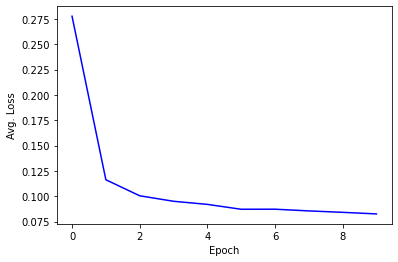


F-Measure: 0.963885 
Accuracy: 0.980667
Validation accuracy and f1 have decreased. Ending training.
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18349
           1       0.95      0.97      0.96      7063

    accuracy                           0.98     25412
   macro avg       0.97      0.97      0.97     25412
weighted avg       0.98      0.98      0.98     25412



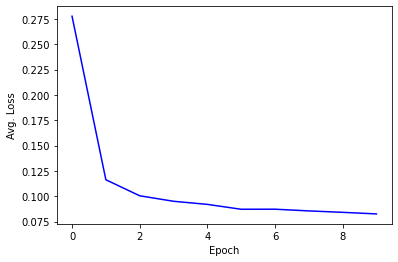

In [11]:
if epoch < epochs:
    for e in range(epoch, epochs):
        loss_total = 0
        random.shuffle(train_dataset.data)
        model.train()
        for n, i in enumerate(range(0, len(train_dataset.data), batch_size)):
            t = time.time()
            # Get the batch
            batch = train_dataset.data[i:min(i+batch_size, len(train_dataset.data))]
            if len(batch) > 0:
                #if network == 'linear':
                tokens = tokenizer([d['Headline'] for d in batch],[d['articleBody'] for d in batch], return_tensors = 'pt', truncation = True, padding = True).to(device)
                targets = torch.LongTensor([0 if d['Stance'] == 'unrelated' else 1 for d in batch]).to(device)

                optimizer.zero_grad()

                # Score the sentence pairs, and calculate/update the loss
                scores = model(tokens)
                #print(scores.shape, targets.shape)
                loss = loss_function(scores, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                loss_total += loss.item()
                optimizer.step()

                t = time.time() - t
                t = ((epochs - 1 - e) * (((len(train_dataset.data) // batch_size) + 1) * t)) + ((((len(train_dataset.data) - i - batch_size) // batch_size) + 1) * t)

                sys.stdout.write('\rEpoch: %d | Number of Trained Pairs: %d/%d | Avg Loss for Last Batch: %f | Remaining Time: %d:%d' % (
                    e,
                    i + batch_size,
                    len(train_dataset.data),
                    loss.item(),
                    t // 60,
                    int(t % 60)
                    ))

        run_data['loss'] += [loss_total / (n + 1)]
        display.clear_output(wait = True)
        plt.clf()
        plt.ylabel('Avg. Loss')
        plt.xlabel('Epoch')
        plt.plot(run_data['loss'], color = 'b')
        display.display(plt.gcf())

        # Test the network after every epoch
        model.eval()
        with torch.no_grad():
            pred_arr, target_arr = [], []
            for i in range(0, len(valid_dataset), batch_size):
                batch = valid_dataset[i:min(i+batch_size, len(valid_dataset))]
                if len(batch) > 0:
                    tokens = tokenizer([d['Headline'] for d in batch],[d['articleBody'] for d in batch], return_tensors = 'pt', truncation = True, padding = True).to(device)
                    targets = [0 if d['Stance'] == 'unrelated' else 1 for d in batch]

                    scores = model(tokens)
                    preds = torch.argmax(F.softmax(scores, dim=-1), dim=-1).cpu().numpy()

                    pred_arr += list(preds)
                    target_arr += targets

            f1 = f1_score(target_arr, pred_arr)
            run_data['valid_f1'] += [f1]
            acc = accuracy_score(target_arr, pred_arr)
            run_data['valid_acc'] += [acc]
            print('\nF-Measure: %3f' % f1, '\nAccuracy: %3f' % acc)
        
        try:
            if run_data['valid_acc'][-1] < run_data['valid_acc'][-2] and run_data['valid_f1'][-1] < run_data['valid_f1'][-2]:
                print('Validation accuracy and f1 have decreased. Ending training.')
                break
        except:
            pass

        # Checkpoint after every epoch
        torch.save(model.state_dict(), 'models/%s_%s_epoch_%d.pth' % (network, mode, e))
        np.save('models/%s_%s.npy' % (network, mode), np.array([run_data['loss'], run_data['valid_acc'], run_data['valid_f1']]))
        print(run_data['loss'])


model.eval()
with torch.no_grad():
    pred_arr, target_arr = [], []
    for i in range(0, len(train_dataset.data), batch_size):
        batch = test_dataset.data[i:min(i+batch_size, len(test_dataset.data) - 1)]
        if len(batch) > 0:
            tokens = tokenizer([d['Headline'] for d in batch], [d['articleBody'] for d in batch], return_tensors = 'pt', truncation = True, padding = True).to(device)
            targets = [0 if d['Stance'] == 'unrelated' else 1 for d in batch]

            scores = model(tokens)
            preds = torch.argmax(F.softmax(scores, dim=-1), dim=-1).cpu().numpy()

            pred_arr += list(preds)
            target_arr += targets

    #data = f1_score(target_arr, pred_arr)
    #acc = accuracy_score(target_arr, pred_arr)
    #print('\nF-Measure: %3f' % data, '\nAccuracy: %3f' % acc)

    report = classification_report(target_arr, pred_arr)
    print(report)

        
del model
torch.cuda.empty_cache()

In [12]:
class Tfidf_Cls(nn.Module):
    def __init__(self, hidden_dim, classes):
        super(Tfidf_Cls, self).__init__()
        self.hidden_dim = hidden_dim
        self.classes = classes
        
        self.fc1 = nn.Linear(41988, self.hidden_dim)
        #self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fc3 = nn.Linear(self.hidden_dim, classes)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, input_vec):
        output = self.dropout(self.activation(self.fc1(input_vec)))
        #output = self.dropout(self.activation(self.fc2(output)))
        return self.fc3(output)
    
def get_tfidf_vec(headline, body, vocab):
    headline_vecs, body_vecs = [], []
    for h, b in zip(headline, body):
        vec = TfidfVectorizer(ngram_range=(1,1), max_df=0.8, min_df=2, vocabulary = vocab)
        headline_vecs += [vec.fit_transform([h]).toarray()]
        body_vecs += [vec.transform([b]).toarray()]
        
    return torch.FloatTensor(headline_vecs).to(device), torch.FloatTensor(body_vecs).to(device)

In [13]:
network = 'linear'
mode = 'tfidf'
lr = 0.001

model = Tfidf_Cls(64, 2).to(device)

# Use NLLLoss in conjunction with LogSoftmax for classification tasks
loss_function = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = optim.AdamW(model.parameters(), lr = lr)

# Load the training dataset
train_dataset = Dataset(clean = True, balance = False, validation=True)
valid_dataset = train_dataset.validation
test_dataset = Dataset(name='competition_test', clean = True)

vec = TfidfVectorizer(ngram_range=(1,1), max_df=0.8, min_df=2)
vec.fit(train_dataset.all_text + test_dataset.all_text)
vocab = vec.vocabulary_

# Load latest checkpointed model if available
epoch = 0
for i in range(epochs):
    if os.path.isfile('models/%s_%s_epoch_%d.pth' % (network, mode, i)):
        model.load_state_dict(torch.load('models/%s_%s_epoch_%d.pth' % (network, mode, i)))
        epoch = i + 1
        
# Load tracked data for the model if available
run_data = {'loss':[], 'valid_acc': [], 'valid_f1': []}
if os.path.isfile('models/%s_%s.npy' % (network, mode)):
    temp = np.load('models/%s_%s.npy' % (network, mode))
    run_data['loss'] = list(temp[0])
    run_data['valid_acc'] = list(temp[1])
    run_data['valid_f1'] = list(temp[2])
    
print(epoch, len(run_data['loss']))

0 0


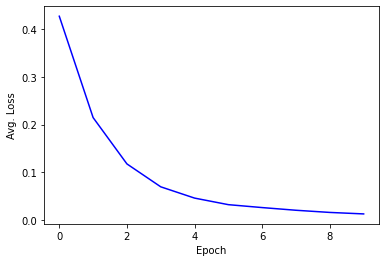


F-Measure: 0.990548 
Accuracy: 0.995000
Validation accuracy and f1 have decreased. Ending training.
              precision    recall  f1-score   support

           0       0.97      0.37      0.54     18349
           1       0.37      0.97      0.54      7063

    accuracy                           0.54     25412
   macro avg       0.67      0.67      0.54     25412
weighted avg       0.80      0.54      0.54     25412



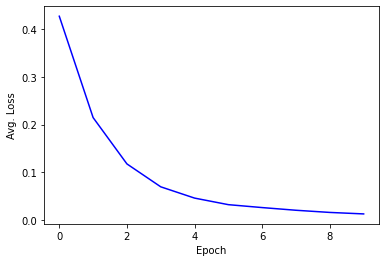

In [14]:
if epoch < epochs:
    for e in range(epoch, epochs):
        loss_total = 0
        random.shuffle(train_dataset.data)
        model.train()
        for n, i in enumerate(range(0, len(train_dataset.data), batch_size)):
            t = time.time()
            # Get the batch
            batch = train_dataset.data[i:min(i+batch_size, len(train_dataset.data))]
            if len(batch) > 0:
                headlines, bodies = get_tfidf_vec([d['Headline'] for d in batch], [d['articleBody'] for d in batch], vocab)
                targets = torch.LongTensor([0 if d['Stance'] == 'unrelated' else 1 for d in batch]).to(device)
                
                optimizer.zero_grad()

                # Score the sentence pairs, and calculate/update the loss
                scores = model(torch.cat((headlines, bodies), dim=-1).squeeze())
                loss = loss_function(scores, targets)
                loss.backward()
                loss_total += loss.item()
                optimizer.step()

                t = time.time() - t
                t = ((epochs - 1 - e) * (((len(train_dataset.data) // batch_size) + 1) * t)) + ((((len(train_dataset.data) - i - batch_size) // batch_size) + 1) * t)

                sys.stdout.write('\rEpoch: %d | Number of Trained Pairs: %d/%d | Avg Loss for Last Batch: %f | Remaining Time: %d:%d' % (
                    e,
                    i + batch_size,
                    len(train_dataset.data),
                    loss.item(),
                    t // 60,
                    int(t % 60)
                    ))

        run_data['loss'] += [loss_total / (n + 1)]
        display.clear_output(wait = True)
        plt.clf()
        plt.ylabel('Avg. Loss')
        plt.xlabel('Epoch')
        plt.plot(run_data['loss'], color = 'b')
        #plt.savefig('loss_plot.png' % model_name)
        display.display(plt.gcf())
        
        # Test the network after every epoch
        model.eval()
        with torch.no_grad():
            pred_arr, target_arr = [], []
            for i in range(0, len(valid_dataset), batch_size):
                batch = valid_dataset[i:min(i+batch_size, len(valid_dataset))]
                if len(batch) > 0:
                    headlines, bodies = get_tfidf_vec([d['Headline'] for d in batch], [d['articleBody'] for d in batch], vocab)
                    targets = [0 if d['Stance'] == 'unrelated' else 1 for d in batch]

                    scores = model(torch.cat((headlines, bodies), dim=-1).squeeze())
                    preds = torch.argmax(F.softmax(scores, dim=-1), dim=-1).cpu().numpy()

                    pred_arr += list(preds)
                    target_arr += targets

            #print(pred_arr)
            f1 = f1_score(target_arr, pred_arr)
            run_data['valid_f1'] += [f1]
            acc = accuracy_score(target_arr, pred_arr)
            run_data['valid_acc'] += [acc]
            print('\nF-Measure: %3f' % f1, '\nAccuracy: %3f' % acc)
        
        try:
            if run_data['valid_acc'][-1] < run_data['valid_acc'][-2] and run_data['valid_f1'][-1] < run_data['valid_f1'][-2]:
                print('Validation accuracy and f1 have decreased. Ending training.')
                break
        except:
            pass

        # Checkpoint after every epoch
        torch.save(model.state_dict(), 'models/%s_%s_epoch_%d.pth' % (network, mode, e))
        np.save('models/%s_%s.npy' % (network, mode), np.array([run_data['loss'], run_data['valid_acc'], run_data['valid_f1']]))

        
model.eval()
with torch.no_grad():
    pred_arr, target_arr = [], []
    for i in range(0, len(train_dataset.data), batch_size):
        batch = test_dataset.data[i:min(i+batch_size, len(test_dataset.data) - 1)]
        if len(batch) > 0:
            headlines, bodies = get_tfidf_vec([d['Headline'] for d in batch], [d['articleBody'] for d in batch], vocab)
            targets = [0 if d['Stance'] == 'unrelated' else 1 for d in batch]

            scores = model(torch.cat((headlines, bodies), dim=-1).squeeze())
            preds = torch.argmax(F.softmax(scores, dim=-1), dim=-1).cpu().numpy()

            pred_arr += list(preds)
            target_arr += targets

    #print(pred_arr)
    #data = f1_score(target_arr, pred_arr)
    #acc = accuracy_score(target_arr, pred_arr)
    #print('\nF-Measure: %3f' % data, '\nAccuracy: %3f' % acc)

    report = classification_report(target_arr, pred_arr)
    print(report)

        
del model
torch.cuda.empty_cache()

In [15]:
network = 'lstm'
mode = 'bert_sentiment'

model = BERT_Cls(64, 3, network).to(device)
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Use NLLLoss in conjunction with LogSoftmax for classification tasks
loss_function = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = transformers.AdamW(model.parameters(), lr = lr)

# Load the training dataset
train_dataset = Dataset(clean = False, balance = False, related_only = True, validation=True)
valid_dataset = train_dataset.validation
test_dataset = Dataset(name='competition_test', clean = False, related_only = True)

# Load latest checkpointed model if available
epoch = 0
for i in range(epochs):
    if os.path.isfile('models/%s_%s_epoch_%d.pth' % (network, mode, i)):
        model.load_state_dict(torch.load('models/%s_%s_epoch_%d.pth' % (network, mode, i)))
        epoch = i + 1
        
# Load tracked data for the model if available
run_data = {'loss':[], 'valid_acc': []}
if os.path.isfile('models/%s_%s.npy' % (network, mode)):
    temp = np.load('models/%s_%s.npy' % (network, mode))
    run_data['loss'] = list(temp[0])
    run_data['valid_acc'] = list(temp[1])
    
stances = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}

In [16]:
if epoch < epochs:
    for e in range(epoch, epochs):
        loss_total = 0
        random.shuffle(train_dataset.data)
        model.train()
        for n, i in enumerate(range(0, len(train_dataset.data), batch_size)):
            t = time.time()
            # Get the batch
            batch = train_dataset.data[i:min(i+batch_size, len(train_dataset.data))]
            if len(batch) > 0:
                #if network == 'linear':
                tokens = tokenizer([d['Headline'] for d in batch],[d['articleBody'] for d in batch], return_tensors = 'pt', truncation = True, padding = True).to(device)
                targets = torch.LongTensor([stances[d['Stance']] for d in batch]).to(device)

                optimizer.zero_grad()

                # Score the sentence pairs, and calculate/update the loss
                scores = model(tokens)
                #print(scores.shape, targets.shape)
                loss = loss_function(scores, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                loss_total += loss.item()
                optimizer.step()

                t = time.time() - t
                t = ((epochs - 1 - e) * (((len(train_dataset.data) // batch_size) + 1) * t)) + ((((len(train_dataset.data) - i - batch_size) // batch_size) + 1) * t)

                sys.stdout.write('\rEpoch: %d | Number of Trained Pairs: %d/%d | Avg Loss for Last Batch: %f | Remaining Time: %d:%d' % (
                    e,
                    i + batch_size,
                    len(train_dataset.data),
                    loss.item(),
                    t // 60,
                    int(t % 60)
                    ))

        run_data['loss'] += [loss_total / (n + 1)]
        display.clear_output(wait = True)
        plt.clf()
        plt.ylabel('Avg. Loss')
        plt.xlabel('Epoch')
        plt.plot(run_data['loss'], color = 'b')
        display.display(plt.gcf())

        # Test the network after every epoch
        model.eval()
        with torch.no_grad():
            pred_arr, target_arr = [], []
            for i in range(0, len(valid_dataset), batch_size):
                batch = valid_dataset[i:min(i+batch_size, len(valid_dataset))]
                if len(batch) > 0:
                    tokens = tokenizer([d['Headline'] for d in batch],[d['articleBody'] for d in batch], return_tensors = 'pt', truncation = True, padding = True).to(device)
                    targets = [stances[d['Stance']] for d in batch]

                    scores = model(tokens)
                    preds = torch.argmax(F.softmax(scores, dim=-1), dim=-1).cpu().numpy()

                    pred_arr += list(preds)
                    target_arr += targets

            acc = accuracy_score(target_arr, pred_arr)
            run_data['valid_acc'] += [acc]
            print('\nAccuracy: %3f' % acc)
        
        try:
            if run_data['valid_acc'][-1] < run_data['valid_acc'][-2]:
                print('Validation accuracy and f1 have decreased. Ending training.')
                break
        except:
            pass

        # Checkpoint after every epoch
        torch.save(model.state_dict(), 'models/%s_%s_epoch_%d.pth' % (network, mode, e))
        np.save('models/%s_%s.npy' % (network, mode), np.array([run_data['loss'], run_data['valid_acc']]))
        print(run_data)


model.eval()
with torch.no_grad():
    pred_arr, target_arr = [], []
    for i in range(0, len(train_dataset.data), batch_size):
        batch = test_dataset.data[i:min(i+batch_size, len(test_dataset.data) - 1)]
        if len(batch) > 0:
            tokens = tokenizer([d['Headline'] for d in batch], [d['articleBody'] for d in batch], return_tensors = 'pt', truncation = True, padding = True).to(device)
            targets = [stances[d['Stance']] for d in batch]

            scores = model(tokens)
            preds = torch.argmax(F.softmax(scores, dim=-1), dim=-1).cpu().numpy()

            pred_arr += list(preds)
            target_arr += targets

    #data = f1_score(target_arr, pred_arr)
    #acc = accuracy_score(target_arr, pred_arr)
    #print('\nAccuracy: %3f' % acc)

    report = classification_report(target_arr, pred_arr)
    print(report)

        
del model
torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       0.54      0.63      0.58      1902
           1       0.47      0.08      0.14       697
           2       0.79      0.83      0.81      4464

    accuracy                           0.70      7063
   macro avg       0.60      0.51      0.51      7063
weighted avg       0.69      0.70      0.68      7063



In [17]:
'''
classifier config:
{
    embedder: str,
    related_params: list,
    related_name: str,
    sentiment_params: list,
    sentiment_name: str,
}
'''

class StanceClassifier():
    def __init__(self, config):
        self.config = config
        
        if self.config['embedder'] == 'bert':
            self.model = BERT_Cls
            self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
        
        elif self.config['embedder'] == 'tfidf':
            self.model = Tfidf_Cls
            
        self.relation = self.model(*self.config['related_params']).to(device)
        self.sentiment = self.model(*self.config['sentiment_params']).to(device)
        self.relation.load_state_dict(torch.load(self.config['related_name']))
        self.sentiment.load_state_dict(torch.load(self.config['sentiment_name']))
        self.relation.eval()
        self.sentiment.eval()
        
    def predict(self, headline, body, vocab = None):
        with torch.no_grad():
            if self.config['embedder'] == 'bert':
                tokens = self.tokenizer(headline, body, return_tensors = 'pt', truncation = True, padding = True).to(device)
            elif self.config['embedder'] == 'tfidf':
                tokens = get_tfidf_vec([headline], [body], vocab)
                tokens = torch.cat(tokens, dim=-1)

            scores = self.relation(tokens).unsqueeze(0)
            pred = torch.argmax(F.softmax(scores, dim=-1), dim=-1).squeeze().cpu().numpy()

            # Stances are: 0-agree, 1-disagree, 2-discuss, 3-unrelated
            if pred == 0:
                return 3

            scores = self.sentiment(tokens).unsqueeze(0)
            pred = torch.argmax(F.softmax(scores, dim=-1), dim=-1).squeeze().cpu().numpy()
        
        return pred        

In [20]:
config = {
    'embedder': 'bert',
    'related_params': [64, 2, 'lstm'],
    'related_name': 'models/lstm_bert_related_epoch_9.pth',
    'sentiment_params': [64, 3, 'lstm'],
    'sentiment_name': 'models/lstm_bert_sentiment_epoch_8.pth',
    'dataset_config': [False, False, False, False]
}

try:
    del classifier
    torch.cuda.empty_cache()
except:
    torch.cuda.empty_cache()

classifier = StanceClassifier(config)

if config['embedder'] == 'bert':
    clean = False
elif config['embedder'] == 'tfidf':
    clean = True
    
train_dataset = Dataset(clean=clean, validation=False)
test_dataset = Dataset(name='competition_test', clean=clean, validation=False)

if config['embedder'] == 'tfidf':
    vec = TfidfVectorizer(ngram_range=(1,1), max_df=0.8, min_df=2)
    vec.fit(train_dataset.all_text + test_dataset.all_text)
    vocab = vec.vocabulary_
else:
    vocab = None
    
train_truths = [stances[d['Stance']] for d in train_dataset.data]
train_preds = []
for d in train_dataset.data:
    train_preds += [classifier.predict(d['Headline'], d['articleBody'], vocab)]
    
report = classification_report(train_truths, train_preds)
print(report)    

test_truths = [stances[d['Stance']] for d in test_dataset.data]
test_preds = []
for d in test_dataset.data:
    test_preds += [classifier.predict(d['Headline'], d['articleBody'], vocab)]
    
report = classification_report(test_truths, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3678
           1       0.80      0.69      0.74       840
           2       0.95      0.98      0.96      8909
           3       1.00      0.99      0.99     36545

    accuracy                           0.98     49972
   macro avg       0.92      0.89      0.90     49972
weighted avg       0.98      0.98      0.98     49972

              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1903
           1       0.41      0.10      0.16       697
           2       0.74      0.85      0.79      4464
           3       0.99      0.98      0.99     18349

    accuracy                           0.91     25413
   macro avg       0.68      0.63      0.63     25413
weighted avg       0.90      0.91      0.90     25413

